# 0. Prerequisites

Load the necessary libraries.

In [15]:
from pymocap.algo import predict_missing_markers
from pymocap.utils import _load_file
from pymocap import preprocessing
from pymocap.algo import *
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.signal import find_peaks

Set the participant ID, and which trial we want to investigate:

In [16]:
participant_id = "pp012"
trial_name = "walk_slow"

In [17]:
# Set data directory
if sys.platform == "win32":
    data_dir = "Z:\\Keep Control\\Data\\lab dataset"
elif sys.platform == "linux":
    data_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

# Get filenames for current trial
omc_file_names = [fname for fname in os.listdir(os.path.join(data_dir, participant_id, "optical")) if fname.endswith(".mat")]
if ("omc_"+trial_name+"_on.mat" in omc_file_names):
    omc_file_name = "omc_" + trial_name + "_on.mat"
elif ("omc_"+trial_name+".mat" in omc_file_names):
    omc_file_name = "omc_" + trial_name + ".mat"
print(f"Marker data file: {omc_file_name:s}")
if os.path.isfile(os.path.join(data_dir, participant_id, "imu", omc_file_name.replace("omc_", "imu_"))):
    imu_file_name = omc_file_name.replace("omc_", "imu_")
else:
    print(f"There is no IMU data file for {omc_file_name:s} of {participant_id:s}. Skip analysis.")
print(f"Sensor data file: {imu_file_name:s}")

Marker data file: omc_walk_slow.mat
Sensor data file: imu_walk_slow.mat


# 1. Get the Data

In [18]:
omc_data = _load_file(os.path.join(data_dir, participant_id, "optical", omc_file_name))
imu_data = _load_file(os.path.join(data_dir, participant_id, "imu", imu_file_name))

Check if data is available for the ankle IMUs and for the relevant markers.

In [19]:
chk = True
my_imus = ["left_ankle", "right_ankle"]
for imu in my_imus:
    if (imu not in imu_data["imu_location"]):
        print(f"Data from {imu:s} is missing. Skip analysis for {imu_file_name:s} of {participant_id:s}.")
        chk = False

my_markers = ["l_heel", "r_heel", "l_toe", "r_toe", "l_psis", "l_asis", "r_psis", "r_asis"]
for marker in my_markers:
    if (marker not in omc_data["marker_location"]):
        print(f"Data from {marker:s} not available from {omc_file_name:s} of {participant_id:s}. Skip analysis.")
        chk = False

# 2. Process IMU Data

In [20]:
# Reshape data
acc = np.reshape(imu_data['acc'], (imu_data['acc'].shape[0], imu_data['acc'].shape[1]*imu_data['acc'].shape[2]), order='F')
gyro = np.reshape(imu_data['gyro'], (imu_data['gyro'].shape[0], imu_data['gyro'].shape[1]*imu_data['gyro'].shape[2]), order='F')
magn = np.reshape(imu_data['magn'], (imu_data['magn'].shape[0], imu_data['magn'].shape[1]*imu_data['magn'].shape[2]), order='F')

# Indexes corresponding to left and right ankle IMU
ix_l_ankle_IMU = np.argwhere(imu_data["imu_location"]=="left_ankle")[:,0][0]
ix_r_ankle_IMU = np.argwhere(imu_data["imu_location"]=="right_ankle")[:,0][0]

# Detect ICs and FCs
ix_l_IC_IMU, ix_l_FC_IMU = salarian(-gyro[:,ix_l_ankle_IMU*3+2], imu_data['fs'])
ix_r_IC_IMU, ix_r_FC_IMU = salarian(gyro[:,ix_r_ankle_IMU*3+2], imu_data['fs'])

# 3. Process OMC Data

In [21]:
# Reshape data
pos = np.reshape(omc_data["pos"][:,:3,:], (omc_data["pos"].shape[0], (omc_data["pos"].shape[1]-1)*omc_data["pos"].shape[2]), order='F')

# Indexes corresponding to left and right heel and toe markers
ix_l_heel = np.argwhere(omc_data["marker_location"]=="l_heel")[:,0][0]
ix_r_heel = np.argwhere(omc_data["marker_location"]=="r_heel")[:,0][0]
ix_l_toe = np.argwhere(omc_data["marker_location"]=="l_toe")[:,0][0]
ix_r_toe = np.argwhere(omc_data["marker_location"]=="r_toe")[:,0][0]
ix_l_psis = np.argwhere(omc_data["marker_location"]=="l_psis")[:,0][0]
ix_r_psis = np.argwhere(omc_data["marker_location"]=="r_psis")[:,0][0]
ix_l_asis = np.argwhere(omc_data["marker_location"]=="l_asis")[:,0][0]
ix_r_asis = np.argwhere(omc_data["marker_location"]=="r_asis")[:,0][0]

start_1 = np.nanmean(omc_data["pos"][:,:3,np.argwhere(omc_data["marker_location"]=="start_1")[:,0][0]], axis=0)
start_2 = np.nanmean(omc_data["pos"][:,:3,np.argwhere(omc_data["marker_location"]=="start_2")[:,0][0]], axis=0)
end_1 = np.nanmean(omc_data["pos"][:,:3,np.argwhere(omc_data["marker_location"]=="end_1")[:,0][0]], axis=0)
end_2 = np.nanmean(omc_data["pos"][:,:3,np.argwhere(omc_data["marker_location"]=="end_2")[:,0][0]], axis=0)

In [22]:
# Try to fill gaps in the marker data
try:
    filled_pos = predict_missing_markers(pos)
except:
    print(f"Could not fill gaps in the marker trajectories. Skip analysis of {omc_file_name:s} of {participant_id:s}.")
    chk = False

In [23]:
# Mid of the start and end markers
mid_start = ( start_1 + start_2 ) / 2
mid_end = ( end_1 + end_2 ) / 2

# Distance from relevant markers to midstart
dist_start_l_psis = np.sqrt(np.sum((filled_pos[:,ix_l_psis*3:ix_l_psis*3+2] - mid_start[:2])**2, axis=1))
dist_start_r_psis = np.sqrt(np.sum((filled_pos[:,ix_r_psis*3:ix_r_psis*3+2] - mid_start[:2])**2, axis=1))
dist_end_l_psis = np.sqrt(np.sum((filled_pos[:,ix_l_psis*3:ix_l_psis*3+2] - mid_end[:2])**2, axis=1))
dist_end_r_psis = np.sqrt(np.sum((filled_pos[:,ix_r_psis*3:ix_r_psis*3+2] - mid_end[:2])**2, axis=1))

# Time index
ix_start = np.min((np.argmin(dist_start_l_psis), np.argmin(dist_start_r_psis)))
ix_start = np.max((0, ix_start))
ix_end   = np.nanmin((np.argmin(dist_end_l_psis), np.argmin(dist_end_r_psis), pos.shape[0]))
print(f"Start index: {ix_start:d}")
print(f"End index: {ix_end:d}")

Start index: 948
End index: 3506


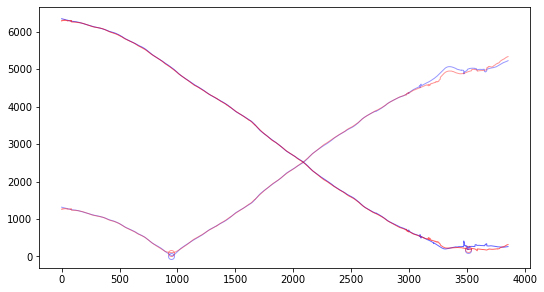

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8.8, 4.8))
ax.plot(dist_start_l_psis, ls='-', lw=1, c=(0, 0, 1, 0.4), label='l_psis')
ax.plot(ix_start, dist_start_l_psis[ix_start], ls='none', marker='o', mfc='none', mec=(0, 0, 1, 0.4), label='start')
ax.plot(dist_start_r_psis, ls='-', lw=1, c=(1, 0, 0, 0.4), label='r_psis')
ax.plot(ix_start, dist_start_r_psis[ix_start], ls='none', marker='o', mfc='none', mec=(1, 0, 0, 0.4), label='start')
ax.plot(dist_end_l_psis, ls='-', lw=1, c=(0, 0, 1, 0.6), label='l_psis')
ax.plot(ix_end, dist_end_l_psis[ix_end], ls='none', marker='o', mfc='none', mec=(0, 0, 1, 0.4), label='end')
ax.plot(dist_end_r_psis, ls='-', lw=1, c=(1, 0, 0, 0.6), label='r_psis')
ax.plot(ix_end, dist_end_r_psis[ix_end], ls='none', marker='o', mfc='none', mec=(1, 0, 0, 0.4), label='end')
plt.show()

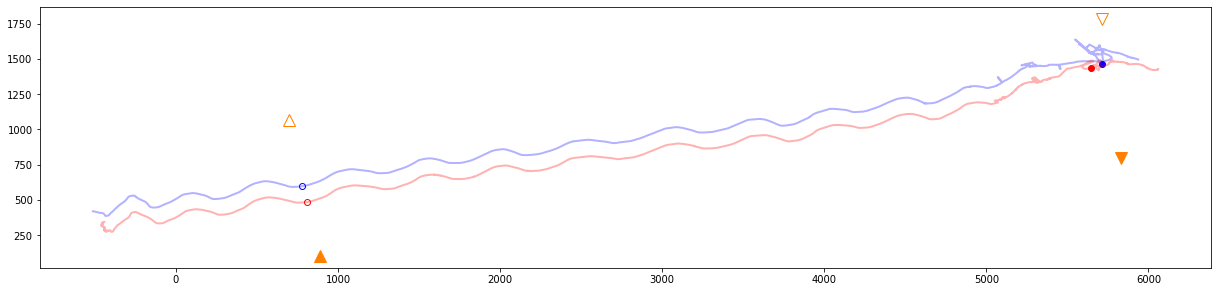

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(21., 4.8))

# Start and end cones
ax.plot(start_1[0], start_1[1], '^', mfc='none', mec=(1, 0.5, 0), ms=12, label='start_1')
ax.plot(start_2[0], start_2[1], '^', mfc=(1, 0.5, 0), mec=(1, 0.5, 0), ms=12, label='start_2')
ax.plot(end_1[0], end_1[1], 'v', mfc='none', mec=(1, 0.5, 0), ms=12, label='end_1')
ax.plot(end_2[0], end_2[1], 'v', mfc=(1, 0.5, 0), mec=(1, 0.5, 0), ms=12, label='start_1')

# Plot psis trajectories
ax.plot(filled_pos[:,ix_l_psis*3], filled_pos[:,ix_l_psis*3+1], ls='-', lw=2, c=(0, 0, 1, 0.3), label='l_psis')
ax.plot(filled_pos[ix_start,ix_l_psis*3], filled_pos[ix_start,ix_l_psis*3+1], ls='none', marker='o', mfc='none', mec=(0, 0, 1), label='l_psis_start')
ax.plot(filled_pos[ix_end,ix_l_psis*3], filled_pos[ix_end,ix_l_psis*3+1], ls='none', marker='o', mfc=(0, 0, 1), mec=(0, 0, 1), label='l_psis_end')
ax.plot(filled_pos[:,ix_r_psis*3], filled_pos[:,ix_r_psis*3+1], ls='-', lw=2, c=(1, 0, 0, 0.3), label='r_psis')
ax.plot(filled_pos[ix_start,ix_r_psis*3], filled_pos[ix_start,ix_r_psis*3+1], ls='none', marker='o', mfc='none', mec=(1, 0, 0), label='r_psis_start')
ax.plot(filled_pos[ix_end,ix_r_psis*3], filled_pos[ix_end,ix_r_psis*3+1], ls='none', marker='o', mfc=(1, 0, 0), mec=(1, 0, 0), label='r_psis_end')
plt.show()

In [26]:
# Detect ICs and FCs
ix_l_IC_OConnor, ix_l_FC_OConnor = oconnor(filled_pos[:,ix_l_heel*3:ix_l_heel*3+3], filled_pos[:,ix_l_toe*3:ix_l_toe*3+3], omc_data['fs'])
ix_r_IC_OConnor, ix_r_FC_OConnor = oconnor(filled_pos[:,ix_r_heel*3:ix_r_heel*3+3], filled_pos[:,ix_r_toe*3:ix_r_toe*3+3], omc_data['fs'])

ix_l_IC_Pijnappels, ix_l_FC_Pijnappels = pijnappels(filled_pos[:,ix_l_heel*3:ix_l_heel*3+3], filled_pos[:,ix_l_toe*3:ix_l_toe*3+3], omc_data['fs'])
ix_r_IC_Pijnappels, ix_r_FC_Pijnappels = pijnappels(filled_pos[:,ix_r_heel*3:ix_r_heel*3+3], filled_pos[:,ix_r_toe*3:ix_r_toe*3+3], omc_data['fs'])

ix_l_IC_Zeni, ix_l_FC_Zeni = zeni(filled_pos[:,ix_l_heel*3:ix_l_heel*3+3], filled_pos[:,ix_l_toe*3:ix_l_toe*3+3], filled_pos[:,ix_l_psis*3:ix_l_psis*3+3], omc_data['fs'])
ix_r_IC_Zeni, ix_r_FC_Zeni = zeni(filled_pos[:,ix_r_heel*3:ix_r_heel*3+3], filled_pos[:,ix_r_toe*3:ix_r_toe*3+3], filled_pos[:,ix_r_psis*3:ix_r_psis*3+3], omc_data['fs'])

In [27]:
# Optionally filter the data
filtered_pos = preprocessing._butter_lowpass_filter(filled_pos, omc_data["fs"], fc=7.)

# Compute velocity signals
vel = np.zeros_like(filtered_pos)
vel[1:,:] = np.diff(filtered_pos, axis=0) / (1/omc_data["fs"])
vel[0,:] = vel[1,:]

# Compute virtual foot center position and velocity
l_foot_center_pos = ( filtered_pos[:,ix_l_heel*3:ix_l_heel*3+3] + filtered_pos[:,ix_l_toe*3:ix_l_toe*3+3] ) / 2
r_foot_center_pos = ( filtered_pos[:,ix_r_heel*3:ix_r_heel*3+3] + filtered_pos[:,ix_r_toe*3:ix_r_toe*3+3] ) / 2

l_foot_center_vel = np.zeros_like(l_foot_center_pos)
l_foot_center_vel[1:,:] = np.diff(l_foot_center_pos, axis=0) / (1/omc_data["fs"])
l_foot_center_vel[0,:] = l_foot_center_vel[1,:]

r_foot_center_vel = np.zeros_like(r_foot_center_pos)
r_foot_center_vel[1:,:] = np.diff(r_foot_center_pos, axis=0) / (1/omc_data["fs"])
r_foot_center_vel[0,:] = r_foot_center_vel[1,:]

# 5. Analyze the Results

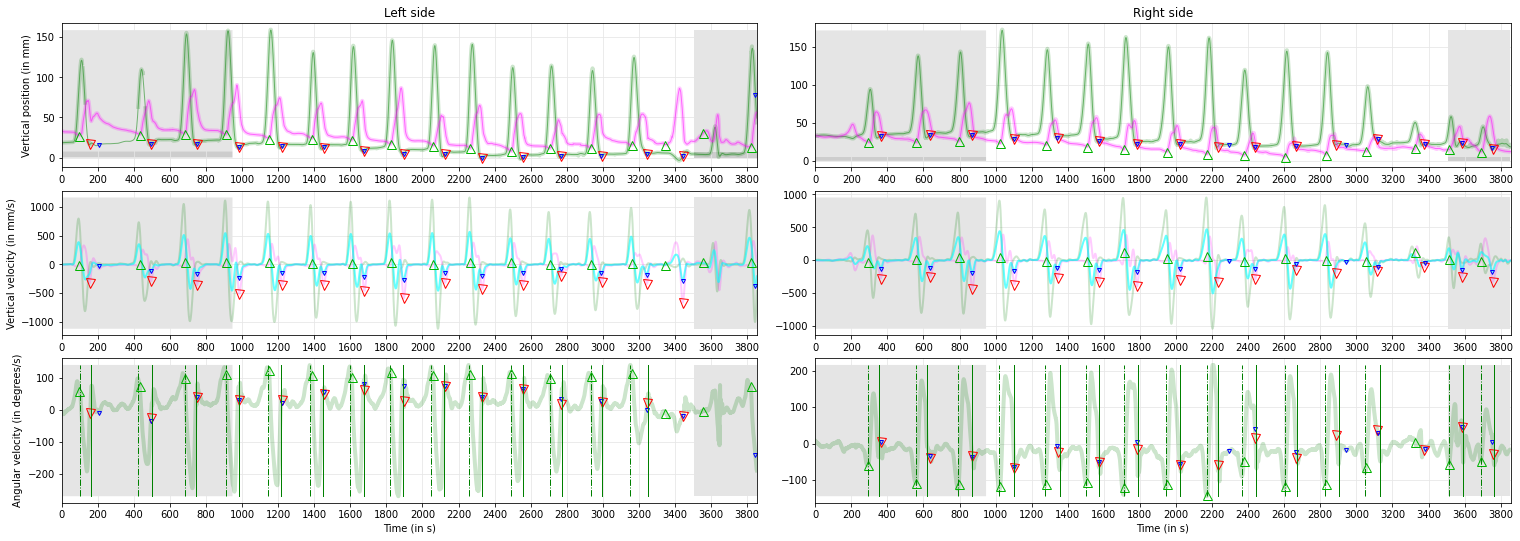

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(21.0, 7.4), constrained_layout=True)

# Gray shaded background
axs[0][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(filtered_pos[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(filtered_pos[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(filtered_pos[:,ix_l_toe*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(filtered_pos[:,ix_l_toe*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(filtered_pos[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(filtered_pos[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(filtered_pos[:,ix_r_toe*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[0][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(filtered_pos[:,ix_r_toe*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')

axs[1][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(vel[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(vel[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(vel[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(vel[:,ix_l_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(vel[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(vel[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(vel[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[1][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(vel[:,ix_r_heel*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')

axs[2][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(gyro[:,ix_l_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(gyro[:,ix_l_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][0].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(gyro[:,ix_l_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][0].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(gyro[:,ix_l_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.max(gyro[:,ix_r_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.max(gyro[:,ix_r_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][1].fill_between(np.arange(0, ix_start), np.ones((ix_start,))*np.min(gyro[:,ix_r_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')
axs[2][1].fill_between(np.arange(ix_end, pos.shape[0]), np.ones((pos.shape[0]-ix_end,))*np.min(gyro[:,ix_r_ankle_IMU*3+2]), color=(0, 0, 0), alpha=0.1, ec='none')

# Left foot
# ---------
# Position
axs[0][0].plot(pos[:,ix_l_heel*3+2], ls='-', lw=4, c=(0, 0.5, 0, 0.2))
axs[0][0].plot(filtered_pos[:,ix_l_heel*3+2], ls='-', lw=1, c=(0, 0.5, 0, 0.5))
axs[0][0].plot(pos[:,ix_l_toe*3+2], ls='-', lw=4, c=(1, 0, 1, 0.2))
axs[0][0].plot(filled_pos[:,ix_l_toe*3+2], ls='-', lw=1, c=(1, 0, 1, 0.5))
axs[0][0].plot(ix_l_IC_Pijnappels, filtered_pos[ix_l_IC_Pijnappels,ix_l_heel*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[0][0].plot(ix_l_IC_OConnor, filtered_pos[ix_l_IC_OConnor,ix_l_heel*3+2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
axs[0][0].plot(ix_l_FC_Zeni, filtered_pos[ix_l_FC_Zeni,ix_l_toe*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
axs[0][0].set_xticks(np.arange(0, pos.shape[0], 200))
axs[0][0].grid(which='major', color=(0.9, 0.9, 0.9))
axs[0][0].set_xlim((0, pos.shape[0]))
axs[0][0].set_ylabel('Vertical position (in mm)')
axs[0][0].set_title('Left side')

# Velocity
axs[1][0].plot(vel[:,ix_l_heel*3+2], ls='-', lw=2, c=(0, 0.5, 0, 0.2))
axs[1][0].plot(vel[:,ix_l_toe*3+2], ls='-', lw=2, c=(1, 0, 1, 0.2))
axs[1][0].plot(l_foot_center_vel[:,2], ls='-', lw=2, c=(0, 1, 1, 0.6))
axs[1][0].plot(ix_l_IC_Pijnappels, vel[ix_l_IC_Pijnappels,ix_l_toe*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[1][0].plot(ix_l_IC_OConnor, l_foot_center_vel[ix_l_IC_OConnor,2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
axs[1][0].plot(ix_l_FC_Zeni, vel[ix_l_FC_Zeni,ix_l_toe*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
axs[1][0].set_xticks(np.arange(0, vel.shape[0], 200))
axs[1][0].grid(which='major', color=(0.9, 0.9, 0.9))
axs[1][0].set_xlim((0, vel.shape[0]))
axs[1][0].set_ylabel('Vertical velocity (in mm/s)')

# Angular velocity
axs[2][0].plot(gyro[:,ix_l_ankle_IMU*3+2], ls='-', lw=4, c=(0, 0.5, 0, 0.2))
axs[2][0].plot(ix_l_IC_Pijnappels, gyro[ix_l_IC_Pijnappels,ix_l_ankle_IMU*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[2][0].plot(ix_l_IC_OConnor, gyro[ix_l_IC_OConnor,ix_l_ankle_IMU*3+2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
for i in range(len(ix_l_IC_IMU)):
    axs[2][0].plot([ix_l_IC_IMU[i], ix_l_IC_IMU[i]], [np.nanmin(gyro[:,ix_l_ankle_IMU*3+2]), np.nanmax(gyro[:,ix_l_ankle_IMU*3+2])], ls='-', lw=1, c=(0, 0.5, 0))
axs[2][0].plot(ix_l_FC_Zeni, gyro[ix_l_FC_Zeni,ix_l_ankle_IMU*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
for i in range(len(ix_l_FC_IMU)):
    axs[2][0].plot([ix_l_FC_IMU[i], ix_l_FC_IMU[i]], [np.nanmin(gyro[:,ix_l_ankle_IMU*3+2]), np.nanmax(gyro[:,ix_l_ankle_IMU*3+2])], ls='-.', lw=1, c=(0, 0.5, 0))
axs[2][0].set_xticks(np.arange(0, gyro.shape[0], 200))
axs[2][0].grid(which='major', color=(0.9, 0.9, 0.9))
axs[2][0].set_xlim((0, gyro.shape[0]))
axs[2][0].set_ylabel('Angular velocity (in degrees/s)')
axs[2][0].set_xlabel('Time (in s)')

# Right foot
# ----------
# Position
axs[0][1].plot(pos[:,ix_r_heel*3+2], ls='-', lw=4, c=(0, 0.5, 0, 0.2))
axs[0][1].plot(filtered_pos[:,ix_r_heel*3+2], ls='-', lw=1, c=(0, 0.5, 0, 0.5))
axs[0][1].plot(pos[:,ix_r_toe*3+2], ls='-', lw=4, c=(1, 0, 1, 0.2))
axs[0][1].plot(filtered_pos[:,ix_r_toe*3+2], ls='-', lw=1, c=(1, 0, 1, 0.5))
axs[0][1].plot(ix_r_IC_Pijnappels, filtered_pos[ix_r_IC_Pijnappels,ix_r_heel*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[0][1].plot(ix_r_IC_OConnor, filtered_pos[ix_r_IC_OConnor,ix_r_heel*3+2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
axs[0][1].plot(ix_r_FC_Zeni, filtered_pos[ix_r_FC_Zeni,ix_r_toe*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
axs[0][1].set_xticks(np.arange(0, pos.shape[0], 200))
axs[0][1].grid(which='major', color=(0.9, 0.9, 0.9))
axs[0][1].set_xlim((0, pos.shape[0]))
axs[0][1].set_title('Right side')

# Velocity
axs[1][1].plot(vel[:,ix_r_heel*3+2], ls='-', lw=2, c=(0, 0.5, 0, 0.2))
axs[1][1].plot(vel[:,ix_r_toe*3+2], ls='-', lw=2, c=(1, 0, 1, 0.2))
axs[1][1].plot(r_foot_center_vel[:,2], ls='-', lw=2, c=(0, 1, 1, 0.6))
axs[1][1].plot(ix_r_IC_Pijnappels, vel[ix_r_IC_Pijnappels,ix_r_toe*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[1][1].plot(ix_r_IC_OConnor, r_foot_center_vel[ix_r_IC_OConnor,2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
axs[1][1].plot(ix_r_FC_Zeni, vel[ix_r_FC_Zeni,ix_r_toe*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
axs[1][1].set_xticks(np.arange(0, vel.shape[0], 200))
axs[1][1].grid(which='major', color=(0.9, 0.9, 0.9))
axs[1][1].set_xlim((0, vel.shape[0]))

# Angular velocity
axs[2][1].plot(gyro[:,ix_r_ankle_IMU*3+2], ls='-', lw=4, c=(0, 0.5, 0, 0.2))
axs[2][1].plot(ix_r_IC_Pijnappels, gyro[ix_r_IC_Pijnappels,ix_r_ankle_IMU*3+2], 'v', mfc='none', mec=(1, 0, 0), ms=9, label="IC (Pijnappels)")
axs[2][1].plot(ix_r_IC_OConnor, gyro[ix_r_IC_OConnor,ix_r_ankle_IMU*3+2], 'v', mfc='none', mec=(0, 0, 1), ms=4, label="IC (O'Connor)")
for i in range(len(ix_r_IC_IMU)):
    axs[2][1].plot([ix_r_IC_IMU[i], ix_r_IC_IMU[i]], [np.nanmin(gyro[:,ix_r_ankle_IMU*3+2]), np.nanmax(gyro[:,ix_r_ankle_IMU*3+2])], ls='-', lw=1, c=(0, 0.5, 0))
axs[2][1].plot(ix_r_FC_Zeni, gyro[ix_r_FC_Zeni,ix_r_ankle_IMU*3+2], '^', mfc='none', mec=(0, 0.7, 0), ms=9, label="FC (Zeni)")
for i in range(len(ix_r_FC_IMU)):
    axs[2][1].plot([ix_r_FC_IMU[i], ix_r_FC_IMU[i]], [np.nanmin(gyro[:,ix_r_ankle_IMU*3+2]), np.nanmax(gyro[:,ix_r_ankle_IMU*3+2])], ls='-.', lw=1, c=(0, 0.5, 0))
axs[2][1].set_xticks(np.arange(0, gyro.shape[0], 200))
axs[2][1].grid(which='major', color=(0.9, 0.9, 0.9))
axs[2][1].set_xlim((0, gyro.shape[0]))
axs[2][1].set_xlabel('Time (in s)')

plt.show()
